# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_datasets(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_datasets('dogImages/train')
valid_files, valid_targets = load_datasets('dogImages/valid')
test_files, test_targets = load_datasets('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print("There are %d total dog categories." % len(dog_names))
print("There are %s total dog images.\n" % len(np.concatenate([train_files, valid_files, test_files], axis=0)))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 3


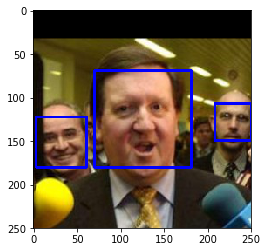

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the iamge
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# convert BGR images to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ <br>
There are 99% of first 100 images in `human_files` detected to have a human face. <br>
There are 11% of first 100 images in `dog_files` detected to have a human face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
from tqdm import tqdm
human_test_acc = (np.array([face_detector(human_img_path) for human_img_path in human_files_short]).astype(int)).mean()
print("Human images test accuracy: %.2f" % human_test_acc)
dog_test_acc = (np.array([face_detector(dog_img_path) for dog_img_path in dog_files_short]).astype(int)).mean()
print("Dog images test accuracy: %.2f" % dog_test_acc)

Human images test accuracy: 0.99
Dog images test accuracy: 0.11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ <br>
There is no dog detected in the images in `human_files_short` (0%) <br> 
All the dog in the images `dog_files_short` are detefcted. (100%)

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

predictions_with_human_images = np.array([dog_detector(human_file) for human_file in human_files_short]).astype(int).mean()
print("Percentage of dog in human images (by Resnet-Dog Detector):", predictions_with_human_images)
predictions_with_dog_images = np.array([dog_detector(dog_file) for dog_file in dog_files_short]).astype(int).mean()
print("Percentage of dog in dog images (by Resnet-Dog Detector):", predictions_with_dog_images)

Percentage of dog in human images (by Resnet-Dog Detector): 0.0
Percentage of dog in dog images (by Resnet-Dog Detector): 1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | -
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 136.83it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ <br>


Note: <br>
Architecture Description: <br>
1. {number of filters}C{kernel_size}({stride})P{pooling_size}({stride})<br>
C: Convolutional Layer; P: Pooling Layer
2. D{number of nodes}<br>
D: Dense Layer
3. GAP: Global Average Pooling

Abbreivations:<br>
1. Ep: Epoch
2. BS: Batch Size
3. Opt: Optimizer
4. Drop: Dropout
5. BN: Batch Normalization
6. lr: Learning Rate

<table>
    
    <tr> <!--headers-->
    <th>Model Number</th>
    <th>Architecture</th>
    <th>Compilation<br>(Ep/BS/Opt)</th>
    <th>Reason/Results</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
    </tr>
    
    <tr> <!--First Implementation-->
    <td>#1</td>
    <td>16C3(1)P3(2)-<br>32C3(1)P3(2)-<br>64C3(1)P3(2)-<br>GAP-<br>D133</td>
    <td>10/20/RMSPROP</td>
    <td>3 sequential concatenation of convolutional and pooling layer could be regarded as 3 levels of hierarchical features. The first block could stand for the color and outline of the dog in picture. The second block may be responsible for the body parts of the dog. Finally, the third block may outline the dog./<br> With this stack of layers, it may be able to detect the dog from other objects. However, in order to classify the dog breeds, the more representative(or breed-specific) features are needed. That is, a deeper CNN architecture must be built to gain those features.
    </td>
    <td>NAN</td>
    <td>NAN</td>
    <td>5.25%</td>
    </tr>

    <tr> <!--Second Implementation-->
    <td>#2</td>
    <td>16C3(1)P3(2)-<br>32C3(1)P3(2)-<br>64C3(1)P3(2)-<br>GAP-<br>D133</td>
    <td>10/20/Adam</td>
    <td>Try to use Adam optimizer to see if the model could get convergence quickly in 20 epochs/<br> With Adam Optimizer, it gets slightly higher test accuracy (1% higher)
    </td>
    <td>~6%</td>
    <td>NAN</td>
    <td>6.3%</td>
    </tr>

    <tr> <!--Third Implementation-->
    <td>#3</td>
    <td>16C5(1)BN-<br>16C3(1)BN-<br>P3(2)-<br>32C3(1)BN-<br>32C3(1)BN-<br>P3(2)-<br>64C3(1)BN-<br>64C3(1)BN-<br>P3(2)-<br>128C3(1)BN-<br>128C3(1)BN-<br>P3(2)-<br>GAP-<br>D133</td>
    <td>10/20/Adam</td>
    <td>Apply more complex model which are the blocks of 2 convolutional layers and 1 pooling layr. Also, I use batch normalization following every convolutional layer to help the model quickly converge. /<br> With this architecture, the validation accuracy quickly gets to 20% in 10 epochs. From the trend of the training and validation loss, the model could be still improved with more epochs or complex architecture. <br>It took around 86 seconds to run an epoch.
    </td>
    <td>38.97%</td>
    <td>20.72%</td>
    <td>NAN</td>
    </tr>

    <tr> <!--Fourth Implementation-->
    <td>#4</td>
    <td>16C5(1)BN-<br>P3(2)<br>32C3(1)BN-<br>32C3(1)BN-<br>P3(2)-<br>64C3(1)BN-<br>64C3(1)BN-<br>P3(2)-<br>128C3(1)BN-<br>128C3(1)BN-<br>P3(2)-<br>256C3(1)BN-<br>P3(2)-<br>GAP-BN-<br>D133</td>
    <td>10/20/Adam</td>
    <td>In this step, I made the model deeper which had a convolutional layer with 256 filters to try to overfit the training dataset./<br> With this architecture, the training accuracy reached 73% in epochs, but the validation accuracy only got to 27%. With this discrepancy, it could be inferred that the model overfitted the training dataset. <br>It took around 66 seconds to run an epoch.
    </td>
    <td>73.67%</td>
    <td>27.66%</td>
    <td>NAN</td>
    </tr>

    <tr> <!--Fifth Implementation-->
    <td>#5</td>
    <td>16C5(1)BN-<br>P3(2)<br>32C3(1)BN-<br>32C3(1)BN-<br>P3(2)-<br>64C3(1)BN-<br>64C3(1)BN-<br>P3(2)-<br>128C3(1)BN-<br>128C3(1)BN-<br>P3(2)-<br>256C3(1)BN-<br>P3(2)-<br>GAP-BN-<br>Drop(0.5)-<br>D133</td>
    <td>10/20/Adam</td>
    <td>In order to prevent overfitting, I added dropout in following the global average pooling layer and its batch normalization./<br> With applying dropout rate (0.5), the training accuracy in 10 epochs was 31.8% and the validation accuracy was 23.1%. From this result, it can be said that the model would need more epochs to train.<br>It took around 66 seconds to run an epoch.
    </td>
    <td>31.87%</td>
    <td>23.11%</td>
    <td>23.68%</td>
    </tr>

    <tr> <!--Sixth Implementation-->
    <td>#6</td>
    <td>16C5(1)BN-<br>P3(2)<br>32C3(1)BN-<br>32C3(1)BN-<br>P3(2)-<br>64C3(1)BN-<br>64C3(1)BN-<br>P3(2)-<br>128C3(1)BN-<br>128C3(1)BN-<br>P3(2)-<br>256C3(1)BN-<br>P3(2)-<br>GAP-BN-<br>Drop(0.5)-<br>D133</td>
    <td>30/20/Adam</td>
    <td>In this step, I trained the model with more epochs, that is 30, to see how the validation loss changed in these 30 epochs/<br>With more epochs, the validatio loss seemed not to decrease since 15 epochs around, but the training loss still decreased after 15 epochs. <br>It took around 67 seconds to run an epoch.
    </td>
    <td>88.76%</td>
    <td>~40.72%</td>
    <td>NAN</td>
    </tr>

    <tr> <!--Seventh Implementation-->
    <td>#7</td>
    <td>16C5(1)BN-<br>P3(2)<br>32C3(1)BN-<br>32C3(1)BN-<br>P3(2)-<br>64C3(1)BN-<br>64C3(1)BN-<br>P3(2)-<br>128C3(1)BN-<br>128C3(1)BN-<br>P3(2)-<br>256C3(1)BN-<br>P3(2)-<br>512C3(1)BN-<br>P3(2)-<br>Drop(0.8)-<br>GAP-BN-<br>Drop(0.5)-<br>D133</td>
    <td>30/20/Adam</td>
    <td>In order to prevent overfitting, I added dropout at the last block of the convolutional layer with max-pooling. Also, I increased the model complexity a little bit (made it deeper)/<br>In 30 epochs, the validatio loss didn't decrease after 15 epochs around, but the training loss still decreased after 15 epochs. This model achieved the test accuracy of 43.3%. The model still overfitted the training dataset <br>It took around 70 seconds to run an epoch. 
    </td>
    <td>82.98%</td>
    <td>~42.63%</td>
    <td>43.3%</td>
    </tr>


</table>

After the training above, I also use L2-regularization for each convolutional layers, but the test accuracy wasn't higher than the #7. To prevent overfitting, image augmentation may be the next step to train this model. Also, the model architecture may need some modification.


In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential


model = Sequential()

### Define architecture. (#~10)

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
__________

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential


model = Sequential()

### Define architecture. (#~10)

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.1))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
__________

In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential


model = Sequential()

### Define architecture. (#~10)

model.add(Conv2D(filters=8, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
#model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 224, 224, 8)       608       
_________________________________________________________________
batch_normalization_18 (Batc (None, 224, 224, 8)       32        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 16)        1168      
_________________________________________________________________
batch_normalization_19 (Batc (None, 56, 56, 16)        64        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 16)        64        
__________

### Compile the Model

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.preprocessing.image import ImageDataGenerator
aug_data_generator = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


aug_data_generator.fit(train_tensors)

In [28]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 30
batch_size = 64

number_of_steps = len(train_tensors) // batch_size

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_aug_3.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit_generator(aug_data_generator.flow(train_tensors, train_targets,batch_size=batch_size),\
                              number_of_steps, epochs=epochs,\
                              verbose=1, callbacks=[checkpointer], validation_data=(valid_tensors, valid_targets))



Epoch 1/30
104/104 [==============================] - 56s - loss: 3.3960 - acc: 0.2147 - val_loss: 3.2974 - val_acc: 0.2575
Epoch 2/30
104/104 [==============================] - 53s - loss: 3.2022 - acc: 0.2320 - val_loss: 3.0353 - val_acc: 0.2695
Epoch 3/30
104/104 [==============================] - 54s - loss: 3.0880 - acc: 0.2418 - val_loss: 3.0832 - val_acc: 0.2587
Epoch 4/30
104/104 [==============================] - 54s - loss: 3.0194 - acc: 0.2562 - val_loss: 3.0364 - val_acc: 0.2671
Epoch 5/30
104/104 [==============================] - 54s - loss: 2.9879 - acc: 0.2550 - val_loss: 3.0401 - val_acc: 0.2814
Epoch 6/30
104/104 [==============================] - 54s - loss: 2.9653 - acc: 0.2601 - val_loss: 3.0159 - val_acc: 0.2659
Epoch 7/30
104/104 [==============================] - 54s - loss: 2.8980 - acc: 0.2650 - val_loss: 2.9144 - val_acc: 0.2778
Epoch 8/30
104/104 [==============================] - 54s - loss: 2.8743 - acc: 0.2684 - val_loss: 3.2642 - val_acc: 0.2515
Epoch 9/

In [ ]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_aug_2.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 34s - loss: 4.6864 - acc: 0.0340 - val_loss: 5.0691 - val_acc: 0.0204
Epoch 2/30
6680/6680 [==============================] - 25s - loss: 4.2116 - acc: 0.0683 - val_loss: 4.3998 - val_acc: 0.0587
Epoch 3/30
6680/6680 [==============================] - 25s - loss: 3.8769 - acc: 0.1133 - val_loss: 4.2522 - val_acc: 0.0898
Epoch 4/30
6680/6680 [==============================] - 25s - loss: 3.6258 - acc: 0.1439 - val_loss: 4.4296 - val_acc: 0.0743
Epoch 5/30
6680/6680 [==============================] - 25s - loss: 3.4175 - acc: 0.1769 - val_loss: 3.9205 - val_acc: 0.1210
Epoch 6/30
6680/6680 [==============================] - 25s - loss: 3.1949 - acc: 0.2156 - val_loss: 4.0322 - val_acc: 0.1186
Epoch 7/30
6680/6680 [==============================] - 25s - loss: 2.9913 - acc: 0.2522 - val_loss: 3.7413 - val_acc: 0.1557
Epoch 8/30
6680/6680 [==============================] - 25s - loss: 2.8

### Plot the training and validation loss curves

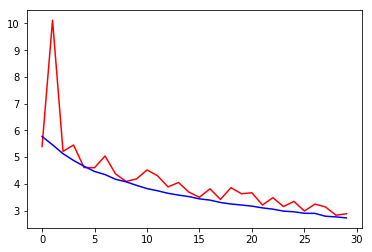

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='r')
plt.plot(history.history['loss'], color='b')

### Load the Model with the Best Validation Loss

In [23]:
model.load_weights('saved_models/weights.best.from_scratch_aug_2.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.6268%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.4631 - acc: 0.1201 - val_loss: 11.2952 - val_acc: 0.1880
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.4259 - acc: 0.2645 - val_loss: 10.3352 - val_acc: 0.2539
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.8908 - acc: 0.3283 - val_loss: 10.0161 - val_acc: 0.3006
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.5645 - acc: 0.3609 - val_loss: 9.8167 - val_acc: 0.3222
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.4239 - acc: 0.3819 - val_loss: 9.8144 - val_acc: 0.3222
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.2229 - acc: 0.3990 - val_loss: 9.6332 - val_acc: 0.3389
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.1241 - acc: 0.4157 - val_loss: 9.5572 - val_acc: 0.3365
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.9216

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.9522%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
  
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [6]:
### obtain bottleneck features from VGG19
VGG19_bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = VGG19_bottleneck_features['train']
valid_VGG19 = VGG19_bottleneck_features['valid']
test_VGG19 = VGG19_bottleneck_features['test']

In [26]:
### obtain bottleneck features from ResNet-50
ResNet50_bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = ResNet50_bottleneck_features['train']
valid_ResNet50 = ResNet50_bottleneck_features['valid']
test_ResNet50 = ResNet50_bottleneck_features['test']

In [14]:
### obtain bottleneck features from Inception
Incep_bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Incep = Incep_bottleneck_features['train']
valid_Incep = Incep_bottleneck_features['valid']
test_Incep = Incep_bottleneck_features['test']

In [9]:
### obtain bottleneck features from Xception
Xc_bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xc = Xc_bottleneck_features['train']
valid_Xc = Xc_bottleneck_features['valid']
test_Xc = Xc_bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ <br>

Note: <br>
Architecture Description: <br>
1. {number of filters}C{kernel_size}({stride})P{pooling_size}({stride})<br>
C: Convolutional Layer; P: Pooling Layer<br>
2. D{number of nodes}<br>
D: Dense Layer<br>
3. GAP: Global Average Pooling


Abbreivations:<br>
1. Ep: Epoch
2. BS: Batch Size
3. Opt: Optimizer
4. Drop: Dropout
5. BN: Batch Normalization
6. lr: learning rate

##### VGG19

<table>
    
    <tr> <!--headers-->
    <th>Model Number</th>
    <th>Architecture</th>
    <th>Compilation<br>(Ep/BS/Opt)</th>
    <th>Reason/Results</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
    </tr>
    
    <tr> <!--First Implementation-->
    <td>#1</td>
    <td>GAP-D(133)</td>
    <td>20/20/RMSprop</td>
    <td>Use global average pooling to condense the features from convolutional layers, and then directly add a dense layer to create logits for 133 dog breeds./<br>
    From the trend of the training and validation loss, it could be inferred that the model underfits the dataset. The training accuracy lied around 60%; The validation accuracy was about 47%. There's no significant increase after 17th epoch.
    </td>
    <td>59%</td>
    <td>47%</td>
    <td>NAN</td>
    </tr>
    
    <tr> <!--Second Implementation-->
    <td>#2</td>
    <td>D(2048)-BN-<br>D(1024)-BN-<br>D(512)-BN-<br>D(133)</td>
    <td>20/20/RMSprop</td>
    <td>Make the model more complex in order to fit the data well./<br>
        The model overfitted the dataset after 3rd epoch. The training acc increased to nearly 97%, but the validation accuracy still unchanged (about 70%)
    </td>
    <td>~97%</td>
    <td>~67%</td>
    <td>NAN</td>
    </tr>
    
    <tr> <!--Third Implementation-->
    <td>#3</td>
    <td>D(2048)-BN-Drop(0.5)-<br>D(1024)-BN-Drop(0.5)-<br>D(512)-BN-Drop(0.5)-<br>D(133)</td>
    <td>20/20/RMSprop</td>
    <td>Add dropout to prevent overfitting/<br>
        The model started overfitting after 10th epoch, which helped the validation accuracy increase to around 75%. 
    </td>
    <td>~91%</td>
    <td>~75%</td>
    <td>75.35%</td>
    </tr>

    
    
</table>

`Note`: I also added L2-regularization in each dense layer, but the results were not better than the third implementation.

##### ResNet-50

<table>
    
    <tr> <!--headers-->
    <th>Model Number</th>
    <th>Architecture</th>
    <th>Compilation<br>(Ep/BS/Opt)</th>
    <th>Reason/Results</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
    </tr>
    
    <tr> <!--First Implementation-->
    <td>#1</td>
    <td>GAP-Drop(0.5)-D(133)</td>
    <td>20/20/RMSprop</td>
    <td>Start with simple model and add in Dropout rate 0.5/ <br> With ResNet-50, I easily got the test accuracy of 80.50%
    </td>
    <td>NAN</td>
    <td>NAN</td>
    <td>80.50%</td>
    </tr>

    <tr> <!--Second Implementation-->
    <td>#2</td>
    <td>GAP-Drop(0.5)-<br>D(1024)-Drop(0.5)<br>-D(133)</td>
    <td>20/20/RMSprop</td>
    <td>Try to make the model more complex (also add dropout following the dense layer with 1024 nodes to prevent overfitting./<br> The training and validation accuracy got stuck around after 15th epoch. There's just nearly 1% increase of the test accuracy with this model.
    </td>
    <td>~84%</td>
    <td>~81%</td>
    <td>81.10%</td>
    </tr>

</table>

##### Inception-V3

<table>
    
    <tr> <!--headers-->
    <th>Model Number</th>
    <th>Architecture</th>
    <th>Compilation<br>(Ep/BS/Opt)</th>
    <th>Reason/Results</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
    </tr>
    
    <tr> <!--First Implementation-->
    <td>#1</td>
    <td>GAP-D(133)</td>
    <td>20/20/Adam</td>
    <td>Start with the simple model. Also, I use adam to make the model converge quickly./ <br> The results showed that the model overfitted the dataset after 8th epoch. The training accuracy got to 99% while the validation accuracy reached 83%.
    </td>
    <td>~99%</td>
    <td>~83%</td>
    <td>NAN</td>
    </tr>

    <tr> <!--Second Implementation-->
    <td>#2</td>
    <td>GAP-Drop(0.5)-D(133)</td>
    <td>20/20/Adam</td>
    <td>Add dropout (0.5) after GAP to prevent overfitting./<br> The model still easily overfitted.
    </td>
    <td>>90%</td>
    <td>~83%</td>
    <td>82.17%</td>
    </tr>
    
    <tr> <!--Third Implementation-->
    <td>#3</td>
    <td>GAP-Drop(0.5)-D(133)</td>
    <td>20/20/Adam (lr:1e-4)</td>
    <td>reduce learning rate to 1e-4/<br> The model still easily overfitted.
    </td>
    <td>>~98%</td>
    <td>~85%</td>
    <td>83.13%</td>
    </tr>
    
    <tr> <!--Fourth Implementation-->
    <td>#4</td>
    <td>GAP-Drop(0.5)-D(133)</td>
    <td>50/20/Adam(lr:1e-5)</td>
    <td> Reduce the learning rate to 1e-4, and increase the number of epochs to 50./ <br> The model performed well than before, although the model still overfitted after 20 or 30 epochs.
    </td>
    <td>~92%</td>
    <td>~87%</td>
    <td>83.61%</td>
    </tr>

</table>

`Training Notes:`
1. Adjusting learning rate would be the priority to consider when the model doesn't perform well.
2. Use Global Average Pooling to condense the featuers from convolutional layers seemed to perform well than flatten the features from convolutional layers.

##### Xception

<table>
    
    <tr> <!--headers-->
    <th>Model Number</th>
    <th>Architecture</th>
    <th>Compilation<br>(Ep/BS/Opt)</th>
    <th>Reason/Results</th>
    <th>Training Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
    </tr>
    
    <tr> <!--First Implementation-->
    <td>#1</td>
    <td>GAP-D(133)</td>
    <td>20/20/Adam(lr:1e-3)</td>
    <td>Also, I started with simple model (use Global average pooling followed by the dense layer with 133 nodes)./ <br> Ovefitting happened after 5 epochs around.
    </td>
    <td>NAN</td>
    <td>NAN</td>
    <td>86.12%</td>
    </tr>

    <tr> <!--Second Implementation-->
    <td>#2</td>
    <td>GAP-Drop(0.7)-D(133)</td>
    <td>20/20/Adam(lr:1e-3)</td>
    <td>Add dropout (0.7) to prevent overfitting./<br> The test result showed that adding dropout didnt help increase the test accuracy.
    </td>
    <td>NAN</td>
    <td>NAN</td>
    <td>85.28%</td>
    </tr>
 
    <tr> <!--Third Implementation-->
    <td>#3</td>
    <td>GAP-BN-D(2048)-<br>BN-Drop(0.7)-<br>D(1024)-BN-Drop(0.7)-<br>D(133)</td>
    <td>20/10/Adam(lr:1e-4)+<br>20/10/Adam(lr:1e-6)</td>
    <td>Applying more dropout with more dense layers and BN to increase the model complexity but also prevent overfitting. I trained the model with learning rate 1e-4 at first 10 epochs and then trained hte model with learning rate 1e-6 to try to enhance the validation and test accuracy./<br> In the first 10 epochs (lr:1e-4), the training accuracy and the validation accuracy I got were nearly 0.82 and 0.85 respectively. At the last 10 epochs (lr:1e-6), the training accuracy slightly increased to 0.85, but the validation stuck around 85~86%. With this implementation, I got test accuracy of 86.60%, which was the best among the first 3 models.
    </td>
    <td>~85%</td>
    <td>~85%</td>
    <td>86.60%</td>
    </tr> 
 
</table>

`Training Notes:`<br>
1. With Adam Optimizer, the model can converge quickly in a few epochs (just 5 epochs). But the learning rate needs to be tuned in order to get higher performance, especially for the test accuracy.


## Transfer Learning with VGG19

In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

### Define model architecture. (for VGG19: GAP-D(133))

model_fromVGG19 = Sequential()

model_fromVGG19.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
model_fromVGG19.add(Dense(133, activation='softmax'))

model_fromVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [54]:
### Define model architecture. (for VGG19: D(2048)-BN-D(1024)-BN-D(512)-BN-D(133)

model_fromVGG19 = Sequential()

model_fromVGG19.add(Flatten(input_shape=train_VGG19.shape[1:]))

model_fromVGG19.add(Dense(2048, activation='relu'))
model_fromVGG19.add(BatchNormalization())
model_fromVGG19.add(Dropout(0.5))
model_fromVGG19.add(Dense(1024, activation='relu'))
model_fromVGG19.add(BatchNormalization())
model_fromVGG19.add(Dropout(0.5))
model_fromVGG19.add(Dense(512, activation='relu'))
model_fromVGG19.add(BatchNormalization())
model_fromVGG19.add(Dropout(0.5))
model_fromVGG19.add(Dense(133, activation='softmax'))

model_fromVGG19.summary()

### (IMPLEMENTATION-VGG19) Compile the Model

In [28]:
### Compile the model (VGG19).
model_fromVGG19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION-VGG19) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
from keras.callbacks import ModelCheckpoint 
### Train the model. (Model from VGG19)

# create model checkpointer
modelCheckpointer_VGG19 = ModelCheckpoint(filepath='saved_models/weights.best.VGG19_#8.hdf5', 
                               verbose=1, save_best_only=True)

# fit the model
history = model_fromVGG19.fit(train_VGG19, train_targets, validation_data=(valid_VGG19, valid_targets),
                   epochs=20, batch_size=20, callbacks=[modelCheckpointer_VGG19], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 53s - loss: 5.7349 - acc: 0.0412 - val_loss: 2.7696 - val_acc: 0.2635
Epoch 2/20
6680/6680 [==============================] - 64s - loss: 3.7923 - acc: 0.1401 - val_loss: 1.8405 - val_acc: 0.4790
Epoch 3/20
6680/6680 [==============================] - 64s - loss: 2.8533 - acc: 0.2578 - val_loss: 1.4589 - val_acc: 0.5545
Epoch 4/20
6680/6680 [==============================] - 64s - loss: 2.3323 - acc: 0.3479 - val_loss: 1.2657 - val_acc: 0.6251
Epoch 5/20
6680/6680 [==============================] - 64s - loss: 1.9636 - acc: 0.4260 - val_loss: 1.1455 - val_acc: 0.6120
Epoch 6/20
6680/6680 [==============================] - 64s - loss: 1.7157 - acc: 0.4847 - val_loss: 1.1110 - val_acc: 0.6515
Epoch 7/20
6680/6680 [==============================] - 64s - loss: 1.5559 - acc: 0.5238 - val_loss: 1.0417 - val_acc: 0.6766
Epoch 8/20
6680/6680 [==============================] - 64s - loss: 1.4

### (IMPLEMENTATION-VGG19) Load the Model with the Best Validation Loss

In [37]:
### Load the model weights with the best validation loss. (Model from VGG19)
model_fromVGG19.load_weights('saved_models/weights.best.VGG19_#8.hdf5')

### (IMPLEMENTATION-VGG19) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [38]:
### Calculate classification accuracy on the test dataset. (Model from VGG19)

# get the predictions of the test dataset from model_fromVGG19

test_predictions_from_VGG19 = [np.argmax(model_fromVGG19.predict(np.expand_dims(test_vector, axis=0))) for test_vector in test_VGG19]

# calculate the accuracy of mode from VGG19

test_accuracy_from_VGG19 = 100*np.sum(np.array(test_predictions_from_VGG19) == np.argmax(test_targets, axis=1))/len(test_predictions_from_VGG19)
print("Test Accuracy from model(VGG19): %.4f%%" % test_accuracy_from_VGG19)


Test Accuracy from model(VGG19): 72.3684%


## Transfer Learning with ResNet-50

In [96]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers
### Define model architecture. (for ResNet-50: GAP-Drop(0.5)-D(133))

model_fromResNet50 = Sequential()

model_fromResNet50.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
model_fromResNet50.add(Dropout(0.5))
model_fromResNet50.add(Dense(133, activation='softmax'))

model_fromResNet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [82]:
### Define model architecture. (for ResNet-50, #2)

model_fromResNet50 = Sequential()

model_fromResNet50.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
model_fromResNet50.add(Dropout(0.5))
model_fromResNet50.add(Dense(1024, activation='relu'))
model_fromResNet50.add(Dropout(0.5))
model_fromResNet50.add(Dense(133, activation='softmax'))

model_fromResNet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_50 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 133)               136325    
Total params: 2,234,501
Trainable params: 2,234,501
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION-ResNet50) Compile the Model

In [42]:
### Compile the model (ResNet50).
from keras import optimizers
opt = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_fromResNet50.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### (IMPLEMENTATION-ResNet-50) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [43]:
### Train the model. (Model from ResNet50)

# create model checkpointer
modelCheckpointer_ResNet50 = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50_#4.hdf5', 
                               verbose=1, save_best_only=True)

# fit the model
history = model_fromResNet50.fit(train_ResNet50, train_targets, validation_data=(valid_ResNet50, valid_targets),
                   epochs=30, batch_size=20, callbacks=[modelCheckpointer_ResNet50], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 5s - loss: 5.0399 - acc: 0.0199 - val_loss: 4.0952 - val_acc: 0.1844
Epoch 2/30
6680/6680 [==============================] - 4s - loss: 4.2329 - acc: 0.0756 - val_loss: 3.0585 - val_acc: 0.3401
Epoch 3/30
6680/6680 [==============================] - 4s - loss: 3.5694 - acc: 0.1434 - val_loss: 2.3701 - val_acc: 0.4491
Epoch 4/30
6680/6680 [==============================] - 4s - loss: 3.0729 - acc: 0.2063 - val_loss: 1.9318 - val_acc: 0.5545
Epoch 5/30
6680/6680 [==============================] - 4s - loss: 2.7598 - acc: 0.2543 - val_loss: 1.6364 - val_acc: 0.6108
Epoch 6/30
6680/6680 [==============================] - 4s - loss: 2.5302 - acc: 0.3037 - val_loss: 1.4168 - val_acc: 0.6467
Epoch 7/30
6680/6680 [==============================] - 4s - loss: 2.4026 - acc: 0.3186 - val_loss: 1.2874 - val_acc: 0.6551
Epoch 8/30
6680/6680 [==============================] - 4s - loss: 2.3197 - ac

### (IMPLEMENTATION-ResNet50) Load the Model with the Best Validation Loss

In [45]:
### Load the model weights with the best validation loss. (Model from ResNet50)
model_fromResNet50.load_weights('saved_models/weights.best.ResNet50_#4.hdf5')

### (IMPLEMENTATION-ResNet50) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [46]:
### Calculate classification accuracy on the test dataset. (Model from ResNet50)

# get the predictions of the test dataset from model_fromResNet50

test_predictions_from_ResNet50 = [np.argmax(model_fromResNet50.predict(np.expand_dims(test_vector, axis=0))) for test_vector in test_ResNet50]

# calculate the accuracy of mode from ResNet50

test_accuracy_from_ResNet50 = 100*np.sum(np.array(test_predictions_from_ResNet50) == np.argmax(test_targets, axis=1))/len(test_predictions_from_ResNet50)
print("Test Accuracy from model(ResNet50): %.4f%%" % test_accuracy_from_ResNet50)


Test Accuracy from model(ResNet50): 77.2727%


## Transfer Learning with Inception-V3

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

### Define model architecture. (for InceptionV3, GAP-Drop-D)

model_fromIncep = Sequential()

model_fromIncep.add(GlobalAveragePooling2D(input_shape=train_Incep.shape[1:]))
model_fromIncep.add(Dropout(0.5))
model_fromIncep.add(Dense(133, activation='softmax'))

model_fromIncep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION-InceptionV3) Compile the Model

In [20]:
### Compile the model (Incep).
from keras import optimizers
opt = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_fromIncep.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### (IMPLEMENTATION-InceptionV3) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint 
### Train the model. (Model from Incep)

# create model checkpointer
modelCheckpointer_Incep = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3#1.hdf5', 
                               verbose=1, save_best_only=True)

# fit the model
history = model_fromIncep.fit(train_Incep, train_targets, validation_data=(valid_Incep, valid_targets),
                   epochs=20, batch_size=20, callbacks=[modelCheckpointer_Incep], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 0.1105 - acc: 0.9612 - val_loss: 0.6106 - val_acc: 0.8587
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.0971 - acc: 0.9671 - val_loss: 0.6099 - val_acc: 0.8659
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.1007 - acc: 0.9647 - val_loss: 0.5973 - val_acc: 0.8599
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.0909 - acc: 0.9684 - val_loss: 0.5955 - val_acc: 0.8551
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.0830 - acc: 0.9737 - val_loss: 0.5918 - val_acc: 0.8551
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.0801 - acc: 0.9720 - val_loss: 0.5979 - val_acc: 0.8611
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.0823 - acc: 0.9720 - val_loss: 0.5998 - val_acc: 0.8599
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.0809 - ac

### (IMPLEMENTATION-InceptionV3) Load the Model with the Best Validation Loss

In [22]:
### Load the model weights with the best validation loss. (Model from Inception_V3)
model_fromIncep.load_weights('saved_models/weights.best.InceptionV3#1.hdf5')

### (IMPLEMENTATION-InceptionV3) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [23]:
### Calculate classification accuracy on the test dataset. (Model from InceptV3)

# get the predictions of the test dataset from model_fromInceptV3

test_predictions_from_Incep = [np.argmax(model_fromIncep.predict(np.expand_dims(test_vector, axis=0))) for test_vector in test_Incep]

# calculate the accuracy of mode from InceptV3

test_accuracy_from_Incep = 100*np.sum(np.array(test_predictions_from_Incep) == np.argmax(test_targets, axis=1))/len(test_predictions_from_Incep)
print("Test Accuracy from model(InceptionV3): %.4f%%" % test_accuracy_from_Incep)


Test Accuracy from model(InceptionV3): 83.1340%


## Transfer Learning with Xception

In [101]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

### Define model architecture. (for Xception, #0)
scale = 1e-4
model_fromXc = Sequential()

model_fromXc.add(GlobalAveragePooling2D(input_shape=train_Xc.shape[1:]))
model_fromXc.add(BatchNormalization())
model_fromXc.add(Dense(2048))#, kernel_regularizer=regularizers.l2(scale)))
model_fromXc.add(BatchNormalization())
model_fromXc.add(Dropout(0.8))
model_fromXc.add(Dense(1024))# kernel_regularizer=regularizers.l2(scale)))
model_fromXc.add(BatchNormalization())
model_fromXc.add(Dropout(0.8))
model_fromXc.add(Dense(133, activation='softmax'))

model_fromXc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_23  (None, 2048)              0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_55 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_29 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_33 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_30 (Batc (None, 1024)              4096      
__________

### (IMPLEMENTATION-Xception) Compile the Model

In [103]:
### Compile the model (Xcep).
from keras import optimizers
opt =optimizers.Adam(lr=1e-8, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_fromXc.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### (IMPLEMENTATION-Xception) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [104]:
from keras.callbacks import ModelCheckpoint 
### Train the model. (Model from Xception)

# create model checkpointer
modelCheckpointer_Xcep = ModelCheckpoint(filepath='saved_models/weights.best.Xception#2.hdf5', 
                               verbose=1, save_best_only=True)

# fit the model
history = model_fromXc.fit(train_Xc, train_targets, validation_data=(valid_Xc, valid_targets),
                   epochs=10, batch_size=20, callbacks=[modelCheckpointer_Xcep], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 12s - loss: 1.0633 - acc: 0.7211 - val_loss: 0.4318 - val_acc: 0.8599
Epoch 2/10
6680/6680 [==============================] - 9s - loss: 1.0169 - acc: 0.7232 - val_loss: 0.4311 - val_acc: 0.8611
Epoch 3/10
6680/6680 [==============================] - 10s - loss: 1.0345 - acc: 0.7160 - val_loss: 0.4311 - val_acc: 0.8635
Epoch 4/10
6680/6680 [==============================] - 9s - loss: 0.9907 - acc: 0.7305 - val_loss: 0.4306 - val_acc: 0.8575
Epoch 5/10
6680/6680 [==============================] - 9s - loss: 1.0262 - acc: 0.7207 - val_loss: 0.4313 - val_acc: 0.8587
Epoch 6/10
6680/6680 [==============================] - 9s - loss: 1.0254 - acc: 0.7235 - val_loss: 0.4321 - val_acc: 0.8587
Epoch 7/10
6680/6680 [==============================] - 10s - loss: 1.0541 - acc: 0.7172 - val_loss: 0.4305 - val_acc: 0.8587
Epoch 8/10
6680/6680 [==============================] - 9s - loss: 1.0425 -

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [105]:
### Load the model weights with the best validation loss. (Model from Xception)
model_fromXc.load_weights('saved_models/weights.best.Xception#2.hdf5')

### (IMPLEMENTATION-Xception) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [106]:
### Calculate classification accuracy on the test dataset. (Model from Xception)

# get the predictions of the test dataset from model_fromInceptV3

test_predictions_from_Xc = [np.argmax(model_fromXc.predict(np.expand_dims(test_vector, axis=0))) for test_vector in test_Xc]

# calculate the accuracy of mode from InceptV3

test_accuracy_from_Xc = 100*np.sum(np.array(test_predictions_from_Xc) == np.argmax(test_targets, axis=1))/len(test_predictions_from_Xc)
print("Test Accuracy from model(Xception): %.4f%%" % test_accuracy_from_Xc)


Test Accuracy from model(Xception): 86.7225%


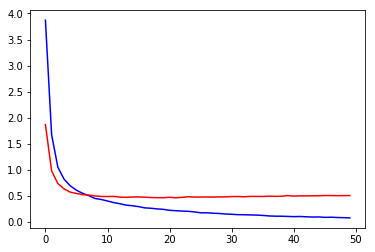

In [94]:
# plot training loss and validation loss
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [107]:
from extract_bottleneck_features import *
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model_fromXc.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### Write your algorithm.
### Feel free to use as many code cells as needed.


In [1]:
# import dependencies
import numpy as np
import cv2
from time import time
import os
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.datasets import load_files
from extract_bottleneck_features import *
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [34]:
current_models = {
"Xception_for_Dog": "weights.best.Xception#2.hdf5",
"InceptionV3_for_Dog": "weights.best.InceptionV3#1.hdf5"
}

class image_interpreter(object):
    '''
    A basic interpreter for any kind of classifer
    '''
    def __init__(self, classifier_name, current_models=current_models, models_path='saved_models', image_database='dogImages/train'):
        '''
        Instantiate the interpreter with classifier name and the path where the model is placed in.
        '''
        
        start_t = time()
        self.classifier_name = classifier_name
        self.models_path = models_path
        
        # check the model name
        self._check_model_name()
        # restore the model
        self._instantiate_classifier()
        # set feature extractor
        self._set_feature_extractor(classifier_name)
        #set up databases
        self._set_matching_database(image_database)
        
        print("Instantiation Duration: %s" % str(time()-start_t))
        
    def _check_model_name(self):
        '''
        Check whether there is a such model under the target path
        '''
            
        try:
            self.model_file_path = os.path.join(self.models_path, current_models[self.classifier_name])
            print("Set the model file path to: %s " % self.model_file_path)
        except KeyError:
            print("The classifier named %s is not found in the given models path" % self.classifier_name)
        
    def _instantiate_classifier(self):
        
        self.classifier = load_model(self.model_file_path)
        print("The classifier %s is restored!" % self.classifier_name)
        
    def _set_feature_extractor(self, classifier_name):
        '''
        :param: classifier_name: the name of the classifier (need to include the model name)
        '''
        self.feature_extractor=None
        
        if "Xception".lower() in classifier_name.lower():
            self.feature_extractor = extract_Xception
            print("The extractor for Xception  is set.")
        elif "Inception".lower() in classifier_name.lower():
            self.feature_extractor = extract_InceptionV3
            print("The extractor for Inception is set.")
        elif "VGG".lower() in classifier_name.lower():
            self.feature_extractor = extract_VGG19
            print("The extractor for VVGG  is set.")
        elif "ResNet".lower() in classifier_name.lower():
            self.feature_extractor = extact_ResNet50
            print("The extractor for ResNet is set.")
            
    def _set_matching_database(self, database_path):
        '''
        :param database_path: the directory for the image database
        '''
        
        # load the database for matching

        data_dict = load_files(database_path, load_content=False)
        self.class_names = np.array(data_dict["target_names"])
        self.image_database = np.array(data_dict['filenames'])
             
    
    def interpret(self, image_src):
        '''
        :param image_src: the path of the image to be loaded
        :return
            figure
        '''
        # load the image
        image = self.load_image(image_src)
        image_tensor = self.path_to_tensor(image_src)
        
        # make first judgement (dog or human) - self.image_content
        self.set_image_content(image_tensor, image)
        
        # get bottle nect features of the model
        bottleneck_feature = self.feature_extractor(np.expand_dims(image_tensor, axis=0))
        
        # calculate the probabilities of being each class
        class_probs = self.classifier.predict(bottleneck_feature)[0]

        self.dog_breed = self.class_names[np.argmax(class_probs)][4:]
        
        # get the most likely two classes of the source images
        most_likely_two_idx = np.argsort(class_probs)[::-1][:2]
        most_likely_two_classes = self.class_names[most_likely_two_idx] #reverse
        most_likely_two_classes_probs = class_probs[most_likely_two_idx]
        
        # get matching images
        matching_images = self.get_matching_images(most_likely_two_classes)
        
        # visualization
        self.description_visualization(image, most_likely_two_classes, most_likely_two_classes_probs, matching_images)

    def set_image_content(self, image, image_src):
        '''
        :param image: the image to be interpreted
        '''
        if self.dog_detector(image):
            self.image_content = 'dog'
        elif self.human_face_detector(image_src):
            self.image_content = 'human'
        else:
            self.image_content = ""
            
    def load_image(self, image_src):
        
        img = cv2.imread(image_src)
        img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def path_to_tensor(self, image_src):
        '''
        :param img_src: the path of the image to be loaded
        :return
            an image
        '''
        
        # loads RGB image as PIL.Image.Image type
        img = image.load_img(image_src, target_size=(224, 224))
        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
        x = image.img_to_array(img)
        return x

        
    def get_matching_images(self, class_names):
        '''
        :param class_names: the class name used for getting the image from database
        :return
            matching image
        '''

        images = []
        for name in class_names:
            # get all images related to the class name
            fetched_images = self.get_images_by_class_name(name)
            # choose a random index
            rand_idx = np.random.randint(0, len(fetched_images))
            # get randomly chosen filepath & load it
            img = cv2.imread(fetched_images[rand_idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        return np.array(images)


    def get_images_by_class_name(self, specific_class_name):
        '''
        :param specific_class_name: the class name to query the related images in database
        :return
            list of the images of the given class
        '''

        return [filepath for filepath in self.image_database if specific_class_name[5:].lower() in filepath.lower()]
        
    def human_face_detector(self, image):
        '''
        :param image: the image to be judged
        :return 
            True/False
        '''
        # extract pre-trained face detector
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
         
        # convert BGR image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # find faces in image
        faces = face_cascade.detectMultiScale(gray)
        
        if len(faces) > 0:
            return True
        else:
            return False
        
    def dog_detector(self, image_tensor):
        '''
        :param img_src: the path of the image to be loaded
        :return
            True/False
        '''

        # get ResNet50 model for prediction whether there is a dog in the image or not
        ResNet50_model = ResNet50(weights='imagenet')
        prediction = np.argmax(ResNet50_model.predict(np.expand_dims(image_tensor, axis=0)))  

        return ((prediction <= 268) & (prediction >= 151)) 
    
    def description_visualization(self, image, possible_classes, possible_classes_probabilities, matching_images):
        '''
        Visualization for the prediction from the model (Find the image in the database which mostly matches the image source)
        :param image: the image to describe (alread loaded)
        :param possible_classes: the possible classes of this image
        :param matching_images: the images from the possible classes (default 2)
        :return:
            figure: the figure contains all the visualization of the image src
        '''
            
        fig = plt.figure(figsize=(8,8))
        
        supt = fig.suptitle(self.get_title_by_main_image_content(), size='x-large', weight='bold', y=0.93)

        
        # elimiate x & y axis
        ax_img_src = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
        ax_similar1 = plt.subplot2grid((2,3), (0,2))
        ax_similar2 = plt.subplot2grid((2,3), (1,2))
        
        # the image
        ax_img_src.imshow(image, aspect='auto')
        ax_img_src.get_yaxis().set_visible(False)
        ax_img_src.set_xticks([])
        ax_img_src.set_xlabel("Your{}image".format(" "+self.image_content+" "))
        
        # the similar 1
        ax_similar1.imshow(matching_images[0], aspect='auto')
        ax_similar1.set_xticks([])
        ax_similar1.get_yaxis().set_visible(False)
        ax_similar1.set_xlabel("{} \n confidence: {:.2f}%".format(possible_classes[0][4:], \
                                                                 possible_classes_probabilities[0]*100), size='medium')
        
        # the similar 2
        ax_similar2.imshow(matching_images[1], aspect='auto')
        ax_similar2.set_xticks([])
        ax_similar2.get_yaxis().set_visible(False)
        ax_similar2.set_xlabel("{} \n confidence: {:.2f}%".format(possible_classes[1][4:], \
                                                                 possible_classes_probabilities[1]*100), size='medium')
             
        plt.show()
        #return fig

    def get_title_by_main_image_content(self):
        
        if self.image_content == 'human':
            return "These are Your dog relatives!"
        elif self.image_content == 'dog':
            return "The dog {} and its relatives".format(self.dog_breed)
        elif self.image_content == "":
            return "Oops! Here are the dogs that resemble the image on the left!"

In [35]:
# Instantiate an image interpreter
interpreter = image_interpreter("Xception_for_Dog")

Set the model file path to: saved_models/weights.best.Xception#2.hdf5 
The classifier Xception_for_Dog is restored!
The extractor for Xception  is set.
Instantiation Duration: 18.867876052856445


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__:<br>
`In my algorithm`, I made it judge the image content first, which would show the dog breed if there's a dog in the image, show the dog relatives if a human face is detected. After the judgement, it would fetch the most likely two dog breeds that resemble the image you give and show the confidence it has about the interpretation.<br>
1. About Performance of my algorithm:<br>
   It correctly interpreted most of the given images, including the dog breeds and the human face. Also, if the algorithm detected an unknown image, it gave a dog breed similar to the object in terms of the color and shape.
2. Possible points of improvement:<br>
* Return an URL that shows the search of that detected dog breeds, which can show more possibly similar images of the given one
* Show the most determinant character the classifier/algorithm used for detecting the dog breeds or fetching the similar dog image.
* 



In [36]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

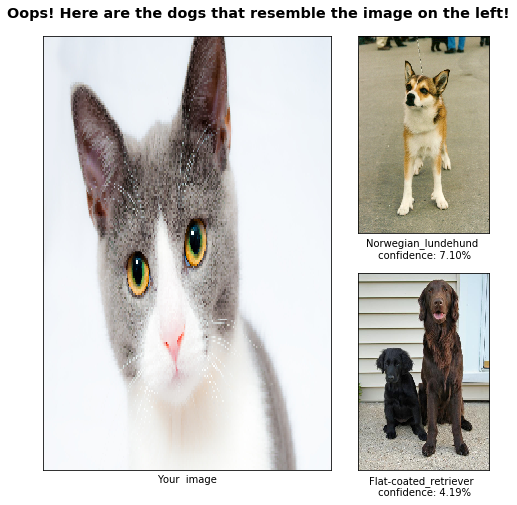

In [37]:
# a cat image
interpreter.interpret('test_samples/cat-pet-animal-domestic-104827.jpeg')

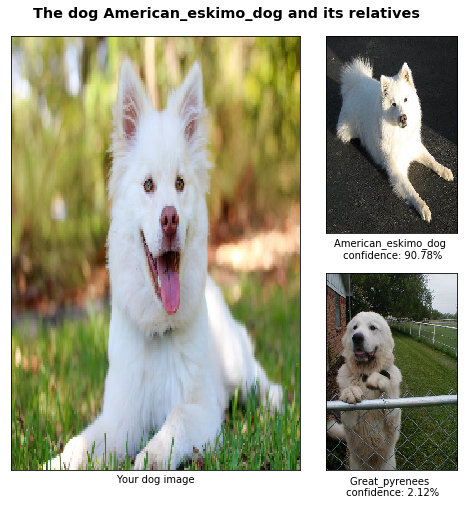

In [39]:
# Dog
interpreter.interpret("test_samples/pexels-photo-356378.jpeg")

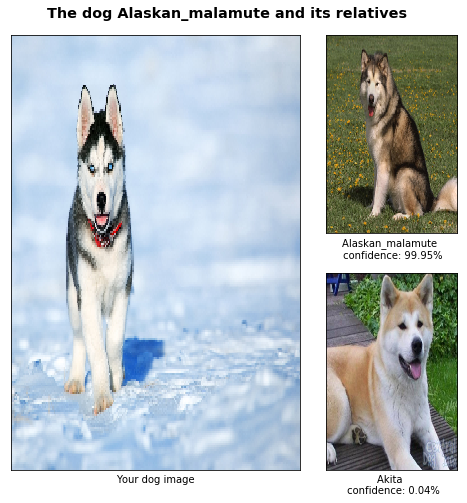

Interpret Duration: 35.57346820831299


In [40]:
# Dog
start_t = time()
interpreter.interpret("test_samples/pexels-photo-434090.jpeg")
print("Interpret Duration:", time()-start_t)

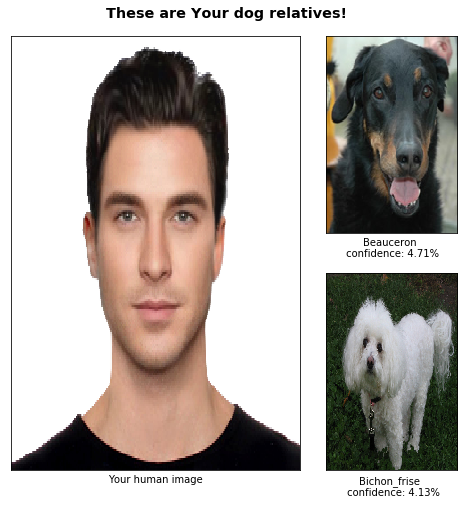

In [41]:
# Human Face
interpreter.interpret("test_samples/Archetypal-Male-Face-of-Beauty-embargoed-to-00.01hrs-30.03.15.jpg")

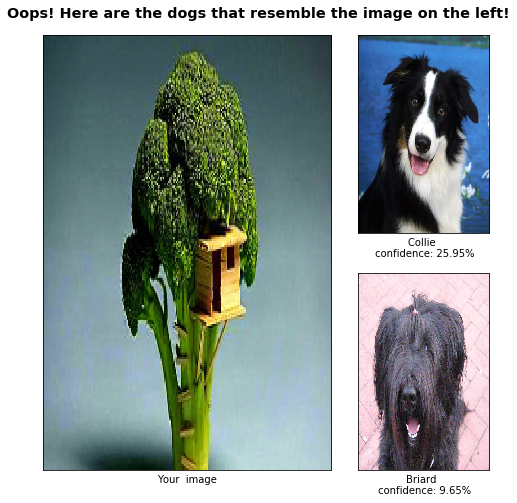

In [42]:
# Object
interpreter.interpret("test_samples/broccoli_460x230.jpg")

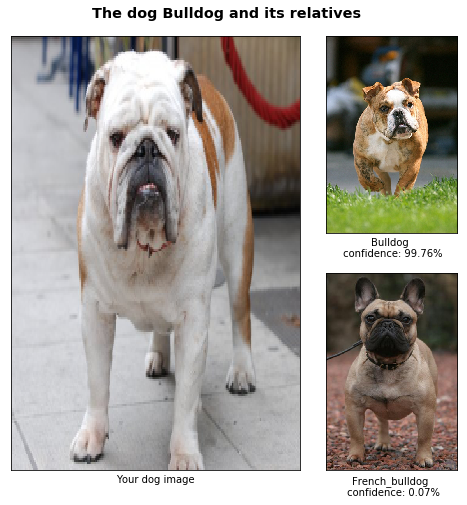

In [43]:
#Dog
interpreter.interpret("test_samples/bulldog-after.jpg")

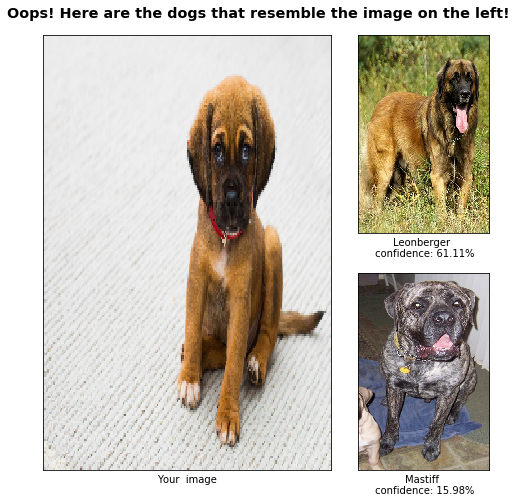

In [44]:
#Dog
interpreter.interpret("test_samples/pexels-photo-59523.jpeg")

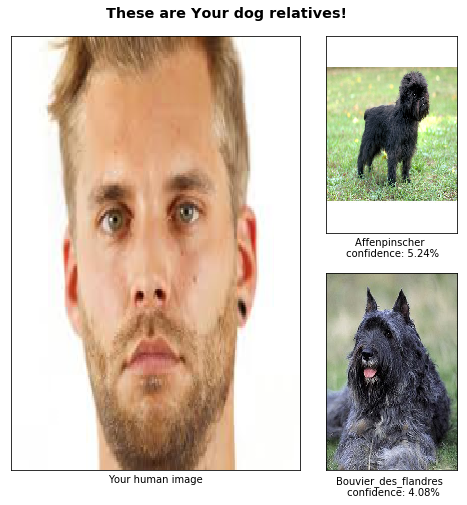

In [45]:
#Human face
interpreter.interpret("test_samples/images.jpeg")